In [1]:
import math, plotly, pickle, os
import plotly.graph_objs as go
import ipywidgets as ipyw
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn import svm, datasets
from sklearn.datasets import make_moons

# kniznice pre vizualizáciu
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.5)
plotly.offline.init_notebook_mode(connected=True)
%matplotlib inline

# modul pre nacitavanie dat
import jupyREADER as jr

def nestFunc():
    return coll.defaultdict(list)

def multipleClassify(dataset='amazon_cells_labelled.txt', train_perc=24, stopWords = []):
    train_perc -= train_perc % 4
    accuraciesW = []
    accuraciesN = []
    jumps = []
    for j in range(5, 205, 5):
        sampleAmount = j*5
        jumps.append(sampleAmount)
        train = sampleAmount*train_perc/100
        likelihood, priors, content = jr.readFile(dataset, train, sampleAmount - train, [])
        accuraciesN.append(classifyTestSet(likelihood, priors, content))
        likelihood, priors, content = jr.readFile(dataset, train, sampleAmount - train, stopWords)
        accuraciesW.append(classifyTestSet(likelihood, priors, content))
    trace0 = go.Scatter(
        x = jumps,
        y = accuraciesW,
        mode = 'lines+markers',
        name = 'so stop-slovami')
    trace1 = go.Scatter(
        x = jumps,
        y = accuraciesN,
        mode = 'lines+markers',
        name = 'bez stop-slov')
    plotly.offline.iplot({
        "data": [trace0, trace1],
        "layout": go.Layout(xaxis = dict(title = 'Počet použitých vzoriek'),
                            yaxis = dict(title = 'Úspešnosť'))})
    
def classifyTestSet(likelihood, priors, content): 
    ''' Tvary trenovacich a testovacich mnozin v dictionary objektoch
    testovacia množina - content   [className][sampleName][words(list)]
    trénovacia množina - likelihood[className][word]        {counted}
    trénovacia množina - prior     [className]              {counted}
    '''
    tSamples = 0; tCorrect = 0
    for className in content:
        for sample in content[className]:
            classPrediction = classifySample(likelihood, priors, content[className][sample])
            if classPrediction == className:
                tCorrect += 1
            tSamples +=1
    return tCorrect / tSamples

def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x = np.linspace(xlim[0], xlim[1], 30)    # 3. arg -> amount of numbers
    y = np.linspace(ylim[0], ylim[1], 30)    # 30 setted
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # cesta
    ax.contour(X, Y, P, 
               colors='k',
               levels=[-1, 0, 1],
               linestyles=['--', '-', '--'])
    
    # podporne vektory
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

def plot_svm(data=10, C=100, ax=None):
    X, y = make_blobs(n_samples=200, centers=2, random_state=9, cluster_std=2.9) 
    X = X[:data]
    y = y[:data]
    model = SVC(kernel='linear', C=C)
    model.fit(X, y)
    plt.figure(figsize=(15,5))
    plt.xlim(-16, 5)
    plt.ylim(-12, 6)
    plt.xlabel('Atribút x')
    plt.ylabel('Atribút y')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='winter')
    plot_svc_decision_function(model, ax)

iris = datasets.load_iris()
X2 = iris.data[:100, :2]
y2 = iris.target[:100]
X3 = iris.data[:, :2]
y3 = iris.target
X1, y1 = make_moons(n_samples=100, noise=0.15, random_state=42)
X1[:,0] += 5
X1[:,1] += 2.5

def funkcia(dataset=2, kernel='rbf', C=100, gamma=1):
    if dataset == 2:
        X = X2
        y = y2
    elif dataset == 3:
        X = X3
        y = y3
    else:
        X = X1
        y = y1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max / x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
     np.arange(y_min, y_max, h))
    X_plot = np.c_[xx.ravel(), yy.ravel()]
    
    svc = svm.SVC(kernel=kernel, C=C, gamma=gamma, decision_function_shape='ovr').fit(X, y)
    Z = svc.predict(X_plot)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(30, 5))
    plt.subplot(122)
    plt.contourf(xx, yy, Z, cmap='bone', alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')
    plt.xlabel('Length')
    plt.ylabel('Width')
    plt.xlim(xx.min(), xx.max())
    plt.show()

# Strojové učenie s Naivným Bayesovským klasifikátorom
<div style="text-align: justify"><br>
    Naivný Bayesovský klasifikátor je algoritmus založený na Bayesovom pravidle ktorý predpovedá kategórie vzorky (vzorkou môže byť napríklad recenzia ktorá nadobúda kategóriu hodnotenia Good alebo Bad). Spôsob klasifikácie prebieha výpočtom pravdepodobností cez všetky možné kategórie do ktorých môže vzorka patriť, pričom kategória s najväčšou pravdepodobnosťou sa použije ako výsledná predpoveď. Na to, aby takéto typy algoritmov <b>(s učiteľom)</b> vedeli niečo predpovedať, potrebujú sa najprv niečo naučiť prostredníctvom <b>trénovacej množiny</b> (training dataset), ktorá pozostáva zo vzoriek s priradenou kategóriou do ktorej patria. Pre jednoduchosť mu poskytneme nasledovný malý dataset s 5 vzorkami textového ohodnotenia určitého produktu a úlohou bude klasifikovať vzorku s neznámou kategóriou hodnotenia Good/Bad:
</div>

| Text vzorky     |Kategória|
|-----------------|---------|
|excellent headset| Good    |
|mic doesnt work  | Bad     |
|love this headset| Good    |
|bad quality mic  | Bad     |
|great mic        | Good    |

<div style="text-align: justify">Na to, aby algoritmy strojového učenia vedeli prečítať vzorky, potrebujú tzv. <b>atribúty</b> (features). Atribúty sú vlastnosti vzoriek na základe ktorých sa algoritmus rozhoduje vo svojich predikciách (v medicíne by tieto vlastnosti mohli byť napr. vek, pohlavie a váha). Po nastavení atribútov a natrénovaní algoritmu sa vygeneruje <b>machine learning model</b>, ktorý je pripravený predikovať neznáme vzorky. Výber podstatných atribútov a prípadne vytváranie nových <b>(feature engineering)</b> pre tieto modely je často krát náročný proces ktorý vyžaduje doménovú znalosť dát, umožňujú však zásadne ovplyvniť efektivitu algoritmov až natoľko, že môžu prekonať iné sofistikovanejšie algoritmy ktoré štandardne dávajú lepšie výsledky.<br>Naivný Bayes v našom prípade používa na reprezentáciu textových dát model <b>bag-of-words</b>, ktorý sa často krát používa aj pri spracovaní prirodzeného jazyka (natural language processing). Tento model spočíva v spočítavaní frekvencií každého slova vo vzorkách pre kategóriu do ktorej spadajú, atribúty sú teda slová a ich hodnoty sú počty výskytov v kategórii. To bude mať za následok zneusporiadanie slov v texte a s každou vzorkou sa teda zaobchádza len ako so súborom početností slov. Celý proces učenia pozostáva v spočítaní týchto frekvencií vo všetkých trénovacích vzorkách pre ich určenú kategóriu, pričom sa v rámci algoritmu Naivného Bayesa taktiež pridáva atribút s počtami vzoriek pre každú kategóriu. Výsledný model sa dá ilustrovať pomocou nasledovnej tabuľky:</div>

|Kategória|excellent|headset|mic|doesnt|work|love|this|bad|quality|great|počet vzoriek|
|---------|---------|-------|---|------|----|----|----|---|-------|-----|-------------|
|Good     |1        |2      |1  |0     |0   |1   | 1  |0  |0      |1    |3            |
|Bad      |0        |0      |2  |1     |1   |0   |0   |1  |1      |0    |2            |

# Bayesové pravidlo
Spôsob vypočítavania pravdepodobností pre všetky kategórie je založený na Bayesovom pravidle vychádzajúci z teórie pravdepodobnosti:<br>

\begin{equation*}
    P(A\mid B)   = \frac{P(B\mid A) \times P(A)}{P(B)}
\end{equation*}<br>

$P(A\mid B)$ \- $\frac{P(A\bigcap B)}{P(B)}$ - pravdepodobnosť kategórie A, ktorá je podmienená javom B (atribútmi) - <b>posterior</b><br>
$P(B\mid A)$ \- $\frac{P(B\bigcap A)}{P(A)}$ - pravdepodobnosť B atribútov, ktorá je podmienená javom A (kategóriou) - <b>likelihood</b><br>
$P(A)$ - pravdepodobnosť kategórie A - <b>prior</b><br>
$P(B)$ - pravdepodobnosť atribútov B<br>

V kontexte textovej klasifikácie vypočítanie pravdepodobnosti kategórie Good pri vzorke obsahujúcej text $excellent\;headset\;mic\;quality$ je možné vyjadriť nasledovnou rovnicou:
$$P(Good\mid excellent\;headset\;mic\;quality) = \frac{P(excellent\;headset\;mic\;quality\mid Good) \times P(Good)}{P(excellent\; headset\; mic\; quality)}$$

Ak hľadáme kategóriu s najvyššou pravdepodobnosťou, nepotrebujeme počítať pravdepodobnosť $P(excellent\;headset\;mic\;quality)$ pretože je rovnaký pre všetky kategórie a výsledok nezmení. V našom prípade teda ide len o porovnanie výsledných pravdepodobností týchto dvoch výrazov:<br><br>
$$P(Good\mid excellent\; headset\; mic\; quality) = P(excellent\; headset\; mic\mid Good) \times P(Good)$$

$$P(Bad\mid excellent\; headset\; mic\; quality) = P(excellent\; headset\; mic\mid Bad) \times P(Bad)$$ 

Použitím spomínaného modelu <b>bag-of-words</b> rozbijeme text na slová a dostaneme nasledovný výraz <b>likelihoodu</b> pre kategóriu Good:<br>

$$P(excellent\; headset\; mic\;quality\mid Good) = P(excellent\mid Good) \times P(headset\mid Good) \times P(mic\mid Good) \times P(quality\mid Good)$$


# Priebeh klasifikácie algoritmu Naivného Bayesa
Naivita tohto klasifikátora spočíva práve vo vypočítavaní pravdepodobností z každých týchto slov zvlášť, čím sa vytvára silný predpoklad, že slová medzi sebou nie sú v žiadnom vzťahu. Klasifikátor sa už teda nepozerá na celú vetu, ale len na ich jednotlivé slová. Takto je možné celý <b>klasifikačný proces</b> vyjadriť nasledovnou formulou:<br>

\begin{equation*}
    \hat{y} = \operatorname*{argmax}_{k\in 1,...,K} \overbrace{P(C_k)}^\text{prior} \overbrace{\prod_{i=1}^{n}P(w_i\mid C_k)}^\text{likelihood}
\end{equation*}

$C_k - \text{aktuálne spracovávaná kategória}$<br>
$w_i - \text{aktuálne vypočítavané slovo}$<br>
$K - \text{počet kategórií}$<br>
$n - \text{počet slov v neznámej vzorke}$<br>

<b>Zhrnutie celého procesu</b>: Hľadáme $argmax$ najpravdepodobnejšiu kategóriu $\hat{y}$ do ktorej môže patriť neznáma vzorka. Pre každú z K možných kategórií sa vypočíta pravdepodobnosť ktorá pozostáva z vynásobenia týchto dvoch pravdepodobností:

- <b>prior</b> $P(C_k)$ - pravdepodobnosť vybratia vzorky s kategóriou $C_k$ zo všetkých vzoriek v trénovacej množine ($\frac{\text{počet vzoriek v}\;C_k\:\text{kategórii}}{\text{počet vzoriek vo všetkých kategóriách}}$)
- <b>likelihood</b> $\prod_{i=1}^{n}P(w_i\mid C_k)$ - pravdepodobnosť pozostávajúca z vynásobení pravdepodobností medzi všetkými n slovami vyskytujúce sa vo vzorke ktorá sa predikuje. Tieto pravdepodobnosti slov sú vypočítavané týmto vzťahom $\frac{\text{počet slov }w_i\text{ v kategórii }C_k}{\text{celkový počet slov v kategórii }C_k}$
    - pri likelihoode môže dôjsť k prípadu slova s nulovou početnosťou, čo spôsobí celkovú nulovú pravdepodobnosť likelihoodu. Preto je potrebné buď nahradiť tieto pravdepodobnosti racionálnym číslom alebo pridať jeden výskyt pre všetky existujúce slová (Laplace smoothing)

Po aplikovaní Laplace smoothingu bude náš model spomenutý na začiatku obsahovať v každej kategórie jedno slovo navyše.

|Kategória|excellent|headset|mic|doesnt|work|love|this|bad|quality|great|počet vzoriek|
|---------|---------|-------|---|------|----|----|----|---|-------|-----|---------|
|Positive |1+1      |2+1    |1+1|0+1   |0+1 |1+1 |1+1 |0+1|0+1    |1+1  |3        |
|Negative |0+1      |0+1    |2+1|1+1   |1+1 |0+1 |0+1 |1+1|1+1    |0+1  |2        |

Celý priebeh výpočtu pravdepodobností oboch kategórií na základe nášho modelu pri vzorke $excellent\;headset\;mic\;quality$ bude vyzerať takto:
$$P(Good\mid excellent\; headset\; mic\; quality) = \overbrace{\frac{1+1}{7+10} \times \frac{2+1}{7+10} \times \frac{1+1}{7+10} \times \frac{0+1}{7+10}}^\text{likelihood} \times \overbrace{\frac{3}{5}}^\text{prior} = 0.000517$$<br>
$$P(Bad\mid excellent\; headset\; mic\; quality) = \frac{0+1}{6+10} \times \frac{0+1}{6+10} \times \frac{2+1}{6+10} \times \frac{1+1}{6+10} \times \frac{2}{5} = 0.000293$$<br>
Výslednou predikciou bude kategória Good s najvyššou vypočítanou pravdepodobnosťou.

# Techniky vylepšenia modelu:
- <b>Stopwordy</b> - použitie stopwordov spočíva v ignorovaní určitých slov, ktoré nemusia obsahovať informačný zisk (the, and, with, a, or, you, we)
- <b>Stemming</b> - process odstraňovania sufixov, prefixov, afixov zo slov na získanie základného tvaru slova (working, work, worked, works -> work)
- <b>Lematizovanie</b> - podobné stemmingu, líši sa schopnosťou zachytiť kánonické formy slov (good, better, cool -> good)
- <b>N-gramy</b> - počítanie sekvencií slov napr. v dvojiciach (excellent quality, headset mic)
- <b>TF-IDF</b> - penalizovanie takých slov, ktoré sa často krát vyskytujú vo väčšine vzoriek, používa sa pre nájdenie stopwordov

<div style="text-align: justify">V nasledujúcom kóde sú implementované funkcie na klasifikovanie ktoré sa dajú spúštať s rôznymi datasetmi pri ktorých je možné nastaviť percentuálny pomer trénovacích a <b>testovacích dát</b> na ktorých sa otestuje klasifikácia. Kedže sa používajú pomerne jednoduché datasety, defaultne nastavený pomer je 24:76 (trénovacie:testovacie) pre lepšie zviditeľnenie rozdielu medzi výsledkami s použitím aj bez použitia stopwordov. Výstupom interakcie je graf s vypočítanou úspešnosťou pri rôznych počtoch použitých vzoriek, ktoré boli rozdelované do trénovacích a testovacích množín.</div>

In [2]:
def classifySample(likelihood, priors, contentSample):
    maxPC = -1E6, ''
    for category in likelihood:
        p = priors[category]                          # počet všetkých vzoriek v kategórii
        n = sum(likelihood[category].values())        # počet všetkých slov v kategórii
        for word in contentSample:
            p *= (likelihood[category][word]+1) / n   # výpočet pravdepodobnosti slova s Laplace smoothingom
        if p > maxPC[0]:
            maxPC = p, category
    return maxPC[1]

stopWords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
ipyw.interact_manual(multipleClassify, dataset={'Amazon reviews': 'amazon_cells_labelled.txt', 'Yelp reviews': 'yelp_labelled.txt', 'Imdb reviews': 'imdb_labelled.txt'}, 
                                train_perc=(4, 100, 4),              # počet vzoriek v každom datasete je 1000
                                stopWords = ipyw.fixed(stopWords));

interactive(children=(Dropdown(description='dataset', options={'Amazon reviews': 'amazon_cells_labelled.txt', …

<div style="text-align: justify">Je pochopiteľné, že čím je väčší pomer trénovacej množiny, tým je vidieť lepšie výsledky a toto relatívne platí aj pri počtoch použitých vzoriek. Pri vyhľadávaní približnej úspešnosti algoritmov strojového učenia sa v praxi často krát používa pomer 80:20 dát. Z grafu je taktiež zrejmé, že aplikovanie stopwordov nemusí vždy pomôcť a často krát úspešnosť záleží na konkrétnych datasetoch. Okrem spomenutých vylepšení modelu boli použité ďalšie iné úpravy pri načítavaní textu, napríklad vymazávanie interpukcií a transformácia veľkých písmen na malé. Existuje množstvo možností predspracovania textu a pri každom datasete môžu vyhovovať iné spracovania. V strojovom učení je táto fáza známa pod názvom <b>predspracovanie dát</b> (data preprocessing). Po získavaní dát od rôznych zdrojov často krát dáta niesú v tom istom formáte, vyskytujú sa v nich chyby a je treba ich transformovať do spoločného formátu aby ich vedel algoritmus čítať.</div>

In [3]:
likelihood, priors, content = jr.readFile('amazon_cells_labelled.txt', 800, 200, stopWords)
priors

FileNotFoundError: [Errno 2] No such file or directory: 'amazon_cells_labelled.txt'

# Vplyv priorov

<div style="text-align: justify">Použité datasety majú približne rovnaký počet vzoriek s negatívnym a pozitívnym ohodnotením. Čím sú tieto rozdiely menšie medzi všetkými možnými kategóriami, tým menší vplyv budú mať priory na výsledok. Kedže v klasifikačnom procese v nich spočíva len jedno vynásobenie s likelihoodom, pri dokumentoch s väčším počtom násobených slov tvoriacich likelihood začnú priory ešte zásadnejšie strácať vplyv na výslednú pravdepodobnosť. Vizualizácia vplyvu týchto priorov na výsledok je možné vidieť vo webovej aplikácii. Obsahuje 3 rôzne datasety s rôznymi vlastnosťami, z ktorých je možné vyberať a kombinovať ich príslušné kategórie pre natrénovanie a následnú klasifikáciu.</div>

Skúsme teraz klasifikovať dataset pozostávajúci z 3 rôznych kategórií článkového textu.

In [4]:
with open(os.path.join("datasets", "jupydash-likelihood"), "rb") as handle:
    likelihood = pickle.loads(handle.read())
with open(os.path.join("datasets", "jupydash-priors"), "rb") as handle:
    priors = pickle.loads(handle.read())
with open(os.path.join("datasets", "jupydash-content"), "rb") as handle:
    content = pickle.loads(handle.read())

print(priors)                # vypisanie kategorií s početnosťou vzoriek
print(classifyTestSet(likelihood, priors, content)) # uspesnost klasifikacie

Counter({'ohsu-Virus_Diseases': 131, 'news-Graphics': 108, 'news-Politics': 102})
0.6173913043478261


<div style="text-align: justify">Vzhľadom na počet kategórií a ich obtiažnosti klasifikácie spočívajúcej z veľmi odlišných domén je 61,7% úspešnosť veľmi slabá. Problém v našej klasifikačnej funkcii spočíva v tom, že násobovaním veľkého počtu pravdepodobností slov v likelihoode sa približuje k tak extrémne malým hodnotám, že ich programovací jazyk zaokrúhli na nulu. Preto je potrebné modifikovať klasifikačnú funkciu tak, že aplikujeme funkciu logaritmus pre každú vypočítanú pravdepodobnosť. Násobenie pravdepodobností slov sa vo forme logaritmov transformuje na sčitovanie a hodnoty prestanú naberať extrémne malé čísla. Výsledná formula celého procesu klasifikácie bude vyzerať nasledovne:</div>
\begin{equation*}
    \hat{y} = \operatorname*{argmax}_{k\in 1,...,K} \overbrace{\text{log}\:P(C_k)}^\text{prior} + \overbrace{\sum_{i=1}^{n}log[P(w_i\mid C_k)]}^\text{likelihood} 
\end{equation*}

In [5]:
def classifySample(likelihood, priors, contentSample):
    maxPC = -1E6, ''
    for category in likelihood:
        p = math.log(priors[category])                        # zlogaritmovaná pravdepodobnosť prioru
        n = sum(likelihood[category].values())
        for word in contentSample:
            p += math.log((likelihood[category][word]+1) / n) # zlogaritmovaná pravdepodobnosť slova
        if p > maxPC[0]:
            maxPC = p, category
    return maxPC[1]

In [6]:
classifyTestSet(likelihood, priors, content)

0.9565217391304348

# Iné varianty klasifikátorov vychádzajúce z Naivného Bayesa
<div style="text-align: justify">Spomenutá metóda klasifikácie je použiteľná len pre diskrétne dáta. Existujú rôzne varianty algoritmov ktoré sa vedia vysporiadať aj so spojitými dátami (obsahujúce racionálne čísla v atribútoch). Tieto varianty je možné nájsť v Pythonovej knižnici <b>scikit-learn</b>, ktorý je najpoužívanejšou knižnicou pre používanie algoritmov strojového učenia. V prípade Naivného Bayesa obsahuje 3 rôzne varianty: <b>Gaussian</b>, <b>Multinomial</b> a <b>Bernoulli</b> Naive Bayes.</div>

<div style="text-align: justify">Naivný Bayes má napriek svojim silným predpokladom nezávislosti atribútov veľké využitie v mnohých situáciách v reálnom svete, používajú sa najmä pri klasifikácií dokumentov a filtrovanie spamu. Väčšinou nemávajú takú úspešnosť ako niektoré iné komplexnejšie algoritmy, majú avšak oproti nim množstvo iných výhod.</div>

# Kedy má Naivný Bayesovský klasifikátor dobré výsledky?
- keď naivný predpoklad závislosti atribútov zodpovedá poskytnutým dátam (zriedkavý prípad v praxi a stáva sa jeho hlavnou nevýhodou)
- pri dobre separovaných kategóriách, keď zložitosť modelu je menej dôležitá
- pri extrémne veľkom počte atribútov, keď zložitosť modelu je menej dôležitá

<div style="text-align: justify">Posledné dva body sa zdajú byť odlišné, no v skutočnosti so sebou súvisia:
Ako <b>dimenzionalita</b> (početnosť atribútov) datasetu raste, klesá pravdepodobnosť, že akékoľvek dva body v priestore budú blizko seba, pretože musia byť blízko v každej jednej dimenzii na to, aby boli blízko celkovo. To znamená, že dáta vo veľkých dimenziách majú tendenciu byť v priemere viac separované ako dáta v nižších dimenziách za predpokladu, že nové dimenzie skutočne pridávajú nejakú informáciu. Z tohto dôvodu môže jednoduchý Naivný Bayesovský klasifikátor práve prostredníctvom naivného predpokladu fungovať veľmi dobre a v niektorých prípadoch aj lepšie ako iné oveľa komplikovanejšie klasifikátory. Pri dostatočnom počte poskytnutých vysoko dimenzionálnych dát môže byť tento algoritmus veľmi úspešný.</div>

# Výhody Naivného Bayesovského klasifikátora
- je extrémne rýchly na trénovanie a klasifikovanie
- ľahko pochopiteľný a jednoduchý na implementáciu
- neobsahuje takmer žiadne nastaviteľné parametre
- vystačí si s malým množstvom trénovacích dát

Vychádzaním z týchto výhod je tento klasifikátor dobrou voľbou obzvlášť pri potrebe rýchleho inicializovania základného modelu klasifikácie.

<div style="text-align: justify"> Naivný Bayesovský klasifikátor opisuje rozdelenie každej kategórie zvlášť a používa tieto <b>generatívne modely</b> tak, aby pravdepodobnostne určili kategórie pre neznáme vzorky. Pri ďalšom algoritme sa zameriame na <b>diskriminatívny model</b>, ktorý spočíva v tom, že namiesto modelovania rozdelení pre každú kategóriu nájdeme oddelovače kategórií v dvoch či viac dimenzionálnych atribútových priestoroch. To znamená, že nebude treba vypočítavať  pravdepodobnosti pre každú kategóriu, stačí sa v prípade dvoch kategórií spýtať, na ktorej z dvoch kategorických strán leží neznáma vzorka priamo v priestore cez jej atribúty.</div>

# Support Vector Machines (SVM)
<div style="text-align: justify">Jednou z najintuitívnejších príkladov ako riešiť klasifikačný problém cez diskriminatívny model je pomocou algoritmu Support Vector Machines. Tento diskriminatívny klasifikátor sa snaží nájsť čiary alebo krivky oddeľujúce 2 kategórie na základe ktorej sa rozhodne, do ktorej kategórie bude neznáma vzorka predikovaná.</div>

<div style="text-align: justify">Predstavme si jednoduchý dataset s dvojdimenzionálnymi dátami (s dvomi atribútmi), pozostávajúci z dvoch ľahko oddeliteľných kategórií. Nebolo by problém nájsť správne oddelujúcu čiaru medzi nimi, problém však nastáva v tom, ako nájsť tú správnu. Existuje ich nekonečné množstvo a každá z nich môže zásadne ovplyvniť úspešnosť predikcie neznámych vzoriek. V nasledujúcom obrázku je možné vidieť niekoľko čiar oddelujúcich trénovacie dáta spolu aj s práve jednou takou neznámou vzorkou ktorá je vyznačená červeným X.</div>

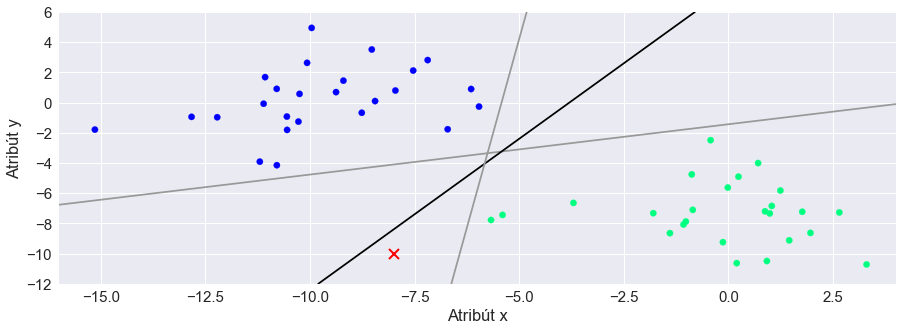

In [7]:
X, y = make_blobs(n_samples=50, centers=2, random_state=9, cluster_std=2) # vytvorenie datasetu
yfit = np.linspace(-12, 6)                                                # vytvor cisla na intervale <-1,3.5>
plt.figure(figsize=(15,5))                                                # velkost grafu
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='winter')                   # trenovacie body
plt.plot([-8], [-10], 'x', color='red', markeredgewidth=2, markersize=10) # testovaci bod
for m, b, c in [[3, 4.3, '0.6'], [0.5, -3.8, '0.0'], [0.1, -5.42, '0.6']]:
    plt.plot(m * yfit + b, yfit, c)                                       # oddelovace
plt.xlabel('Atribút x')
plt.ylabel('Atribút y')
plt.xlim(-16, 4)
plt.ylim(-12, 6);

<div style="text-align: justify">Zo znázornených troch čiar je vidieť, že čierna čiara tieto dáta oddeľuje najlepším spôsobom. Ako ju však máme nájsť a podľa čoho? Je zrejmé, že takáto jednoduchá intuícia kreslenia čiar medzi kategóriami nestačí a hlavnou myšlienkou SVM algoritmu je práve nájsť túto najlepšie oddeľovaciu čiaru.</div>

# Maximalizovanie hraníc dvoch kategórií
Intuícia pre nájdenie najlepšej oddelovacej čiary spočíva v hľadaní čiary s najväčšou hrúbkou (cesta), ohraničenou najbližšie vyskytujúcimi sa bodmi vzoriek. V prípade našich čiar by tieto hrúbky vyzerali nasledovne.

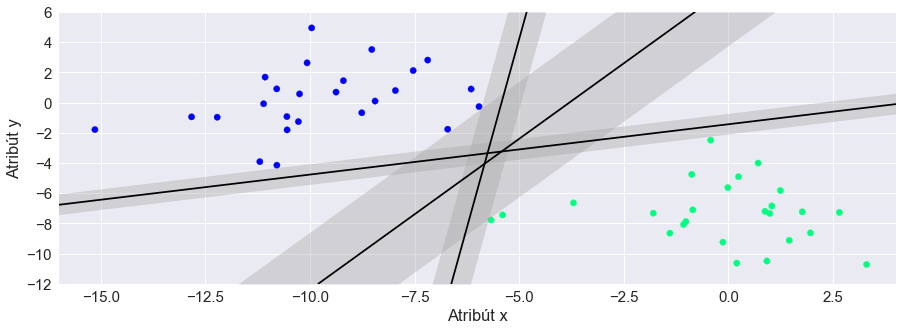

In [8]:
yfit = np.linspace(-12, 6)
plt.figure(figsize=(15,5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='winter')
for m, b, d in [[3, 4.3, 2], [0.5, -3.8, 1.9], [0.1, -5.42, 0.45]]:
    xfit = m * yfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_betweenx(yfit, xfit - d, xfit + d, color='#AAAAAA', alpha=0.4)
plt.xlabel('Atribút x')
plt.ylabel('Atribút y')
plt.xlim(-16, 4)
plt.ylim(-12, 6);

<div style="text-align: justify">Pozrime sa teraz ako túto čiaru nájde samotný SVM algoritmus. Použijeme modul z knižnice scikit-learn pri ktorom nastavíme tzv. kernel linear pre lineárne (čiarové) oddelenie kategórii, význam parametru C bude vysvetlený neskôr. Vo výstupe nasledujúceho kódu je možné vidieť všetky možné nastaviteľné parametre.</div>

In [9]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=100)
model.fit(X, y)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

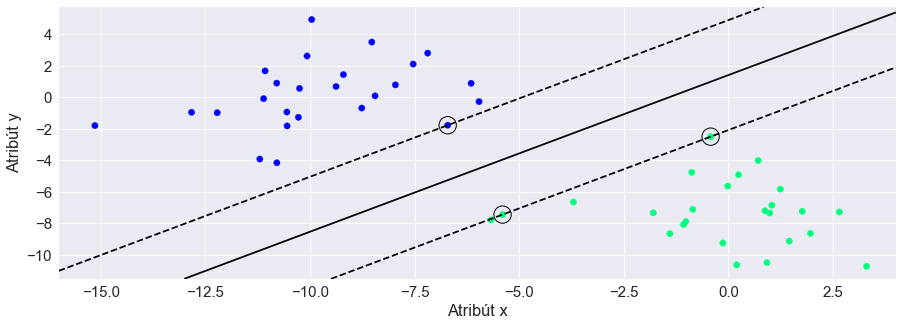

In [10]:
plt.figure(figsize=(15,5))
plt.xlim(-16, 4);
plt.xlabel('Atribút x')
plt.ylabel('Atribút y')
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='winter')
plot_svc_decision_function(model);

<div style="text-align: justify">Plná čiara predstavuje oddeľovaciu čiaru <b>(hyperplane)</b>, ktorá maximalizuje rozpätie <b>(margin)</b> medzi kategóriami prostredníctvom troch vyznačených dátových bodov <b>(podporné vektory alebo support vectors)</b> tvoriace cestu. Tieto body sú kľúčové prvky k vytvoreniu klasifikačného modelu a preto je od nich odvodené meno samotného algoritmu. V scikit-learne sa tieto podporné vektory v klasifikátore ukladajú do atribútu support\_vectors\_:</div>

In [11]:
model.support_vectors_

array([[-6.70705767, -1.7639505 ],
       [-0.42401368, -2.48919677],
       [-5.39599847, -7.43877392]])

<div style="text-align: justify">Kľúčom k úspechu tohto klasifikátora je skutočnosť, že je založený len na umiestnení týchto  podporných vektorov, akékoľvek iné body nachádzajúce sa ďaleko od okrajov vôbec nemenia výsledný tvar klasifikačného modelu. Problém však nastáva pri ťažšom rozpoložení dát s malým rozpätím medzi kategóriami ktorý síce je maximalizovaný a oddeľuje trénovacie dáta perfektným spôsobom, ale často krát to neplatí pri predikciách u neznámych vzorkách, pretože neberie do úvahy frekvencie dát na určitých miestach nachádzajúcich sa za okrajmi. Model sa príliš snaží správne kategorizovať trénovacie dáta, stráca tým však generalizáciu riešenia u neznámych dát a trpí tzv. <b> preučením</b>.</div>

<div style="text-align: justify">Z výstupu nasledujúceho kódu je možné meniť počet dát spolu s penalizačným alebo regularizačným parametrom C, cez ktorý je možné zgeneralizovať chybu pre testovacie dáta. Pri vysokej hodnote C sa algoritmus snaží kategorizovať trénovacie dáta čo najpresnejšie a spôsobuje nájdenie čiary s malým rozpätím. Naopak nízke hodnoty vytvárajú väčšie rozpätie a tolerujú určitú chybu v trénovaní. Zoberie sa tým do úvahy väčšie množstvo podporných vektorov naokolo pomocou ktorého bude výsledný model viac zgeneralizovaný.</div>

<div style="text-align: justify">Príkladom preučenia je najviac vidieť medzi použitím počtov dát 130-140 s veľkým parametrom C. Jedna (modrá) vzorka tam zásadným spôsobom zmenila celý klasifikačný model. Prostredníctvom zníženia parametra C je možné upraviť tento model a zohľadniť viacero bodov na okolo.</div>

In [12]:
ipyw.interact(plot_svm, data=(10, 200, 10), C=ipyw.FloatLogSlider(base=10, value=30,  min=-2, max=1.5, step=0.25), ax=ipyw.fixed(None));

interactive(children=(IntSlider(value=10, description='data', max=200, min=10, step=10), FloatLogSlider(value=…

Čo keď máme dáta ktoré vytvárajú iný tvar rozdelenia kategórií?  

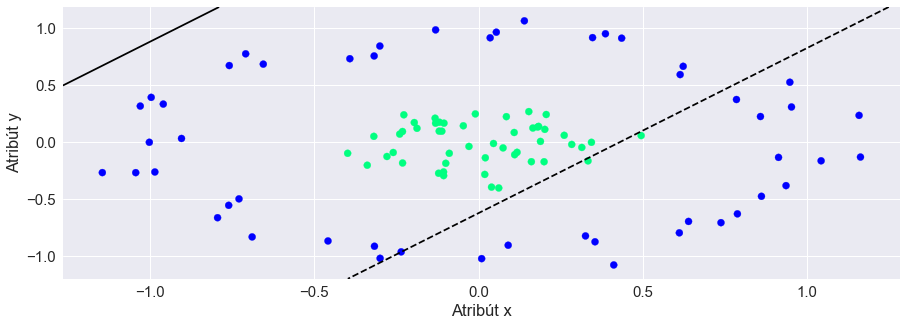

In [13]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.2, noise=.1)

clf = SVC(kernel='linear').fit(X, y)
plt.figure(figsize=(15,5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plt.xlabel('Atribút x')
plt.ylabel('Atribút y')
plot_svc_decision_function(clf, plot_support=False);

<div style="text-align: justify">Je jasne vidieť, že žiadna lineárna diskriminácia nebude nikdy schopná oddeliť takéto rozdelenie dát. Skúsme sa však na ne pozreť z trojrozmernej perspektívy prostredníctvom nasledujúceho grafu.</div>

In [14]:
from mpl_toolkits import mplot3d
r = np.exp(-(X ** 2).sum(1))

def plot_3D(elev=20, azim=20, X=X, y=y):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=40, cmap='winter')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')
ipyw.interact(plot_3D, elev=(0, 90, 10), azim=(0, 90, 10), X=ipyw.fixed(X), y=ipyw.fixed(y));

interactive(children=(IntSlider(value=20, description='elev', max=90, step=10), IntSlider(value=20, descriptio…

# Použitie viacrozmerného priestoru
<div style="text-align: justify">Je jasné, že s touto dodatočnou dimenziou sa už tieto dáta dajú jednoducho rozdeliť prostredníctvom taktiež navýšenej dimenzie oddelovača - plochy, ktorá by sa ideálne mohla nachádzať v r=0.7. Ak by tieto dáta boli ešte komplikovanejšie rozložené, potrebovali by sme použiť ešte väčší dimenzionálny priestor. Taký sa už ale ťažko vizualizuje a nieto ešte rozdeluje.</div><br>

<div style="text-align: justify">Hlavný trik SVMiek spočíva práve v tom, že vie prevádzať atribúty do nekonečne rozmerného priestoru prostredníctvom tzv. <b>kernelového triku</b> tak, aby ich vedel následne rozdelovať analogickým spôsobom ako pri dvojrozmerných dát. Jeden zo známych používaných kernelov je kernel RBF (<b>radial basis function</b>), ktorý je možné v scikit-learne nastaviť pri inicializovaní SVM modelu.</div>

In [15]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Pomocou tohto kernelizovaného SVM modelu je klasifikátor naučený separovať kategórie nelineárnym spôsobom, ktorý je ilustrovaný na nasledujúcom obrázku.

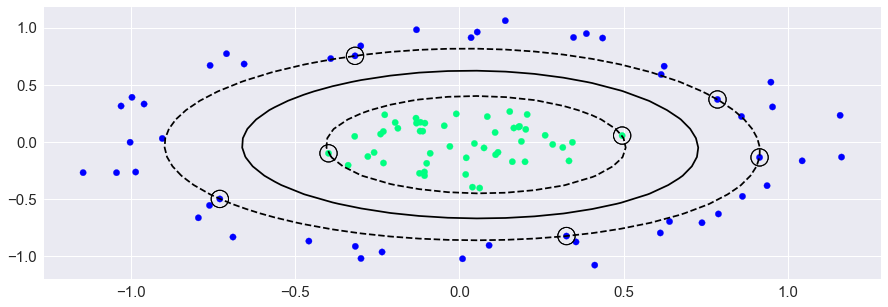

In [16]:
fig = plt.figure(figsize=(15,5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='winter')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=300, lw=1, facecolors='none', edgecolors='k');

# Klasifikácia viacerích kategórií
<div style="text-align: justify">Doteraz sme používali len binárnu klasifikáciu pre 2 rôzne kategórie. Na to, aby sme mohli predikovať väčší počet kategórií je treba problém transformovať na viacero binárnych klasifikačných podproblémov. Používajú sa nasledovné 2 prístupy:</div>

1. <b>One-vs-all</b> - počas trénovania sa vytvorí klasifikátor pre každú kategóriu, pričom vzorky príslušných kategórií sú pozitívne a všetky ostatné sú negatívne. Pri klasifikácií sa vyberie ten klasifikátor, ktorý má najširšie okrajové rozdelenie. 
2. <b>One-vs-one</b> - počas trénovania sa vytvára klasifikátor pre každý možný pár kategórií. V čase predikcie sa používa schéma hlasovania a kategória s najvyšším počtom predpovedí sa použije ako výsledok. Výhoda tohto prístupu nad one-vs-all spočíva v lepšej vyváženosti výsledných rozdelení medzi kategóriami, nevýhodou je ale oveľa pomalšie trénovanie kedže obsahuje celkovo K(K-1)/2 klasifikátorov. V praxi sa väčšinou používa prvý prístup.

# Hyperparametre
<div style="text-align: justify">Pri každom datasete na ktorý chceme aplikovať algoritmy strojového učenia je potrebné vyhľadať vhodné parametre pre čo najoptimálnejší model. Tieto parametre sa nazývajú <b>hyperparametre</b>. Najštandardnejším hyperparametrom je už spomínaný regularizačný parameter ktorý sa často používa pri väčšine algoritmov strojového učenia. V prípade SVM existuje ešte jeden hyperparameter γ (gamma), ktorý je nastaviteľný pri RBF kerneli. Prostredníctvom tohto parametra vieme nastaviť do akej miery chceme tvarovať komplexné tvary tak, aby zodpovedali trénovacím dátam. Čím je väčší, tým je model náchylnejší k preučeniu.</div><br>

<div style="text-align: justify">Z výstupu nasledujúceho kódu je možné nastavovať tieto parametre a pozorovať ich vplyv na vytváranie SVM klasifikačných modelov. Použijeme pri tom známy dataset iris ktorý sa načíta zo scikit-learnu.</div>

In [17]:
ipyw.interact(funkcia, dataset={'Iris (2 kategórie)': 2, 'Iris (3 kategórie)': 3, 'Moons (2 kategórie)': 1},
                  kernel={'Radial Basis Function': 'rbf', 'Linear': 'linear'},
                  C=ipyw.FloatLogSlider(base=10, value=10,  min=-2, max=4, step=0.5), 
              gamma=ipyw.FloatLogSlider(base=10, value=0.1, min=-4, max=2, step=0.5)); # len pre RBF

interactive(children=(Dropdown(description='dataset', options={'Iris (2 kategórie)': 2, 'Iris (3 kategórie)': …

<div style="text-align: justify">Jeden z prístupov hľadania vhodných hyperparametrov pre zlepšenie úspešnosti na konkrétnom datasete je možné manuálne, intuitívne či hrubou silou. Pri vyhľadávaní hrubou silou sa používa tzv. <b>GridSearch</b>, ktorý prehľadáva mriežky všetkých možných parametrov pre určité algoritmy</div><br>
<div style="text-align: justify">SVM algoritmus bol pred neurónovými sieťami najpopulárnejší klasifikačný algoritmus v strojovom učení. Osvedčil sa kvôli svojej vysokej presnosti a flexibilite použitia pri rôznorodých dát. Okrem klasifikácie sa taktiež používa aj pri <b>regresii</b> kde sa namiesto klasifikácie kategórie predikuje číselná hodnota. Dobre vysvetlený a matematicky odvodený SVM je možné vidieť v prednáške od Patricka Winstona https://www.youtube.com/watch?v=_PwhiWxHK8o</div>

# Výhody:
 - veľká rýchlosť klasifikácie
 - kernelový trik zabezpečuje univerzálnosť modelu pre rôznorodé dáta
 - kompaktný model zaberajúci málo pamäti prostredníctvom závislosti od pomerne málo podporných vektorov 
 - narozdiel od väčšiny iných algoritmov fungujú veľmi dobre s vysoko rozmernými dátami ktoré môžu aj presahovať celkový počet vzoriek

# Nevýhody:
 - pomalá rýchlosť trénovania pri veľkých datasetoch
 - finálny model je ťažko interpretovateľný
 - nájdenie správnych parametrov kernelu nieje jednoduché najmä pri veľkom počte dát 

<div style="text-align: justify">Vzhľadom na tieto charakteristiky sa odporúčajú SVMka používať najmä vtedy, keď nám výsledky iných algoritmov s menšími požiadavkami na ladenie hyperparametrov nestačia. Toto platí najmä pri veľkom počte dát. Ak máme dostupnú vysokú výpočtovú silu pre natrénovanie a nastavovanie hyperparametrov, môže táto metóda viesť k vynikajúcim výsledkom.</div>